In [1]:
from nb_helpers import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

Importing:

import os
from os.path import join as jp

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from dpipe.config import get_resource_manager
from dpipe.medim.visualize import slice3d
from dpipe.io import load_json


In [3]:
import imageio

In [61]:
grad = imageio.imread('./gradient-h.png')[..., 0]
lena = imageio.imread('./lena512.bmp')

In [254]:
def show(func, downsampling=1):
    axes = plt.subplots(1, 2, figsize=(15, 10))[1]
    for a, i in zip(axes, [grad, lena]):
        a.imshow(func(i[::downsampling, ::downsampling]), cmap='gray')
        a.set_axis_off()

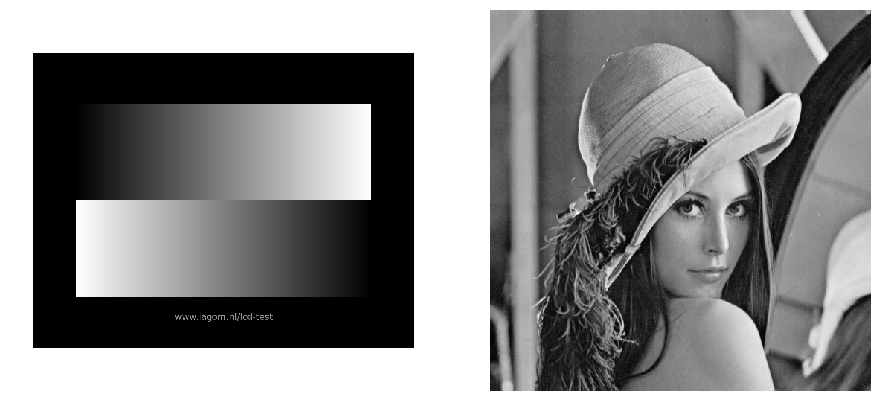

In [257]:
show(lambda x: x)

In [215]:
def simple_thresholding(image):
    return 255 * (image > 127)

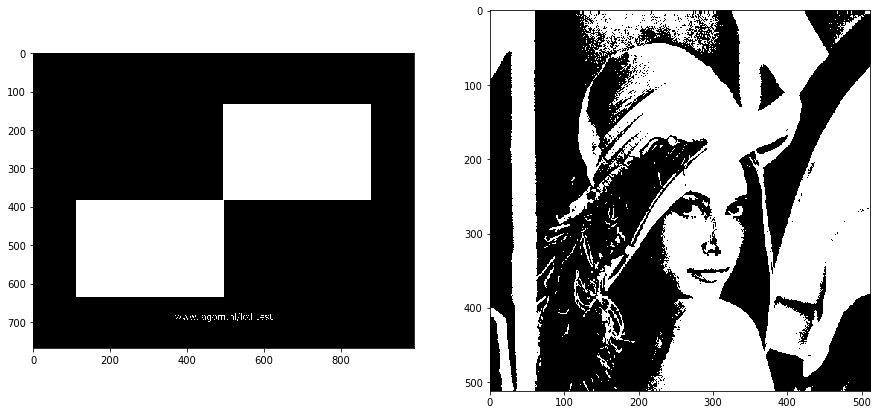

In [74]:
show(simple_thresholding)

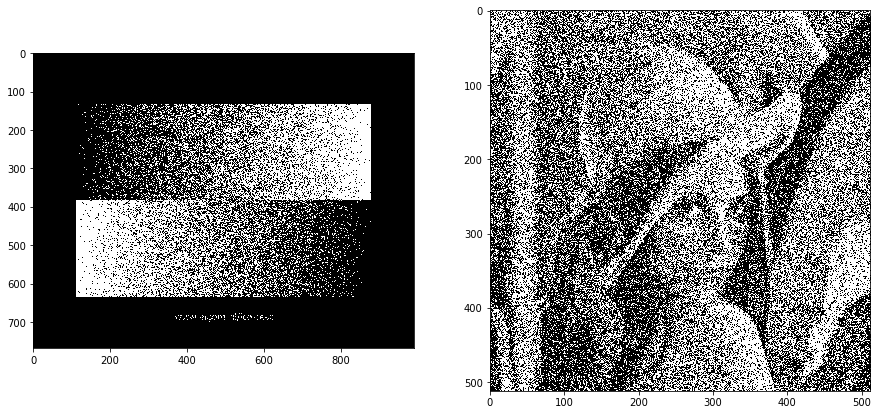

In [78]:
def random_dithering(image):
    return 255 * (image > np.random.randint(256, size=image.shape))

show(random_dithering)

In [99]:
from tqdm import tqdm_notebook as tqdm

In [178]:
dithering_matrix = np.array([[0, 2], [3, 1]]) / 4

def build_slices(start, stop):
    return tuple(map(slice, start, stop))


def make_dithering_matrix(order):
    if order < 2 or (order & (order - 1)) != 0:
        raise ValueError('Order must be a power of 2: %d' % order)
    
    if order == 2:
        return dithering_matrix
    
    area = order ** 2
    prev = area * make_dithering_matrix(order // 2)
    return np.concatenate([
        np.concatenate([prev, prev + 2], 1), 
        np.concatenate([prev + 3, prev + 1], 1)
    ]) / area


def ordered_dithering(image, order=2):
    matrix = 256 * make_dithering_matrix(order)
    scale = np.ceil(np.array(image.shape) / matrix.shape).astype(int)
    tiles = np.tile(matrix, scale)
    
    return image > tiles[build_slices([0, 0], image.shape)]

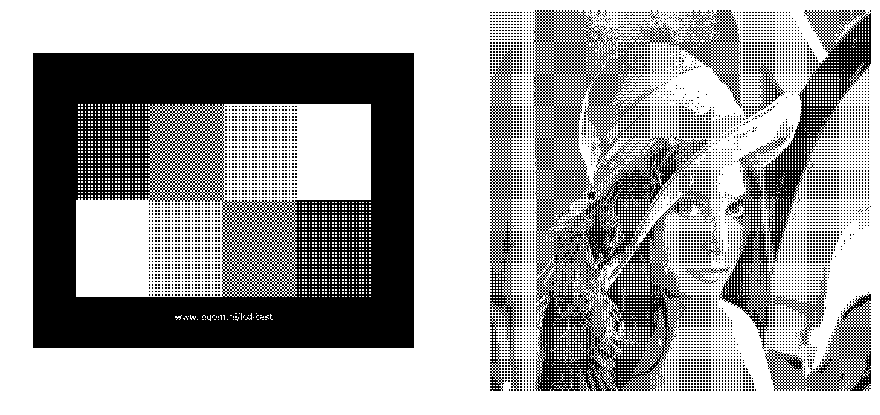

In [179]:
show(lambda x: ordered_dithering(x, 2))

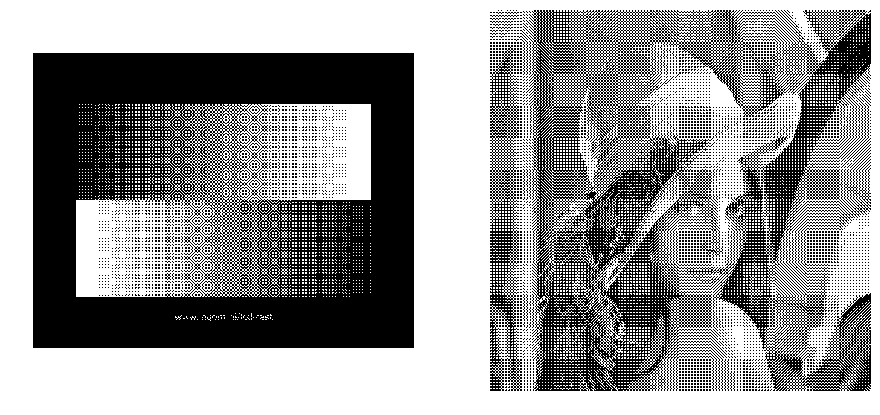

In [184]:
show(lambda x: ordered_dithering(x, 4))

In [216]:
def row_diffusion(row):
    row = row.copy().astype(int)
    for i in range(len(row)):
        old_value = row[i]
        row[i] = simple_thresholding(old_value)
        if i < len(row) - 1:
            row[i + 1] += old_value - row[i]
        
    return row.astype('uint8')

def error_diffusion(image):
    return np.stack(map(row_diffusion, image))

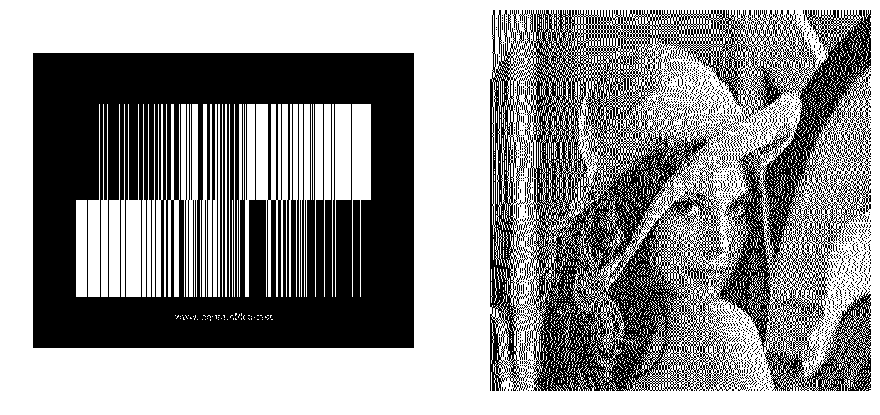

In [217]:
show(error_diffusion)

In [218]:
def two_orders_error_diffusion(image):
    result = np.empty_like(image)
    result[:, ::2] = error_diffusion(image[:, ::2])
    result[:, 1::2] = error_diffusion(image[:, 1::2][:, ::-1])[:, ::-1]
    return result

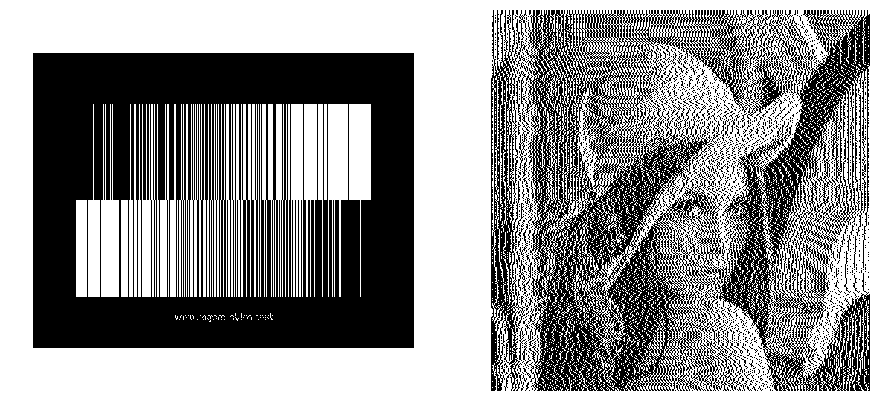

In [212]:
show(two_orders_error_diffusion)

In [260]:
f_s_matrix = np.array([[0, 0, 7], [3, 5, 1]]) / 16
    

def floyd_steinberg(image):
    image = image.copy().astype(float)
    shape = np.array(image.shape) - [1, 2]
    for x, y in np.ndindex(*shape):
        idx = (x, y + 1)
        window_start = np.array([x, y], int)
        
        old_value = image[idx]
        image[idx] = simple_thresholding(old_value)
        error = old_value - image[idx]
        
        slc = build_slices(window_start, window_start + f_s_matrix.shape)
        image[slc] += f_s_matrix * error
        
    return simple_thresholding(image)

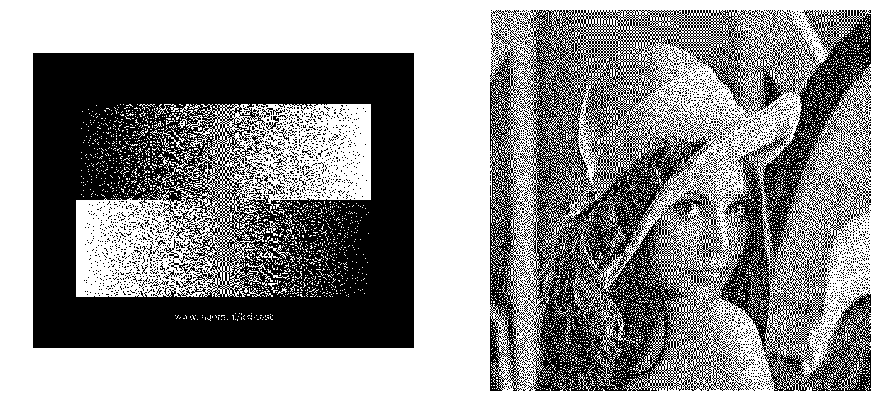

In [263]:
show(floyd_steinberg)